In [33]:
import tensorflow as tf
from keras import layers as tfkl
import tensorflow.keras as tfk

from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.data import Dataset
import numpy as np
import pandas as pd
import os
import nrrd
from dataclasses import dataclass
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import cv2

In [96]:
@dataclass
class HyperParams:
    batch_size = 128
    activation = "silu"
    learning_rate = 1e-4
    num_epochs = 100
    input_shape = (96, 96, 3)
    num_classes = 5
    ## Early stopping parameters
    es_patience = 15
    es_min_delta = 1e-4
    ## Learning rate schedule
    lr_patience = 5
    lr_decay_factor = 0.5
    lr_min_delta = 1e-4
    min_lr = 1e-6
hp = HyperParams()

In [35]:
def lung_ct_to_rgb(hu_image, lung_window=(-1000, -400), tumor_window=(30, 80), colormap=cv2.COLORMAP_HOT):
    lung_lower, lung_upper = lung_window
    lung_clipped = np.clip(hu_image, lung_lower, lung_upper)
    lung_normalized = ((lung_clipped - lung_lower) / (lung_upper - lung_lower) * 255).astype(np.uint8)

    tumor_lower, tumor_upper = tumor_window
    tumor_clipped = np.clip(hu_image, tumor_lower, tumor_upper)
    tumor_normalized = ((tumor_clipped - tumor_lower) / (tumor_upper - tumor_lower) * 255).astype(np.uint8)

    base_rgb = cv2.cvtColor(lung_normalized, cv2.COLOR_GRAY2BGR)
    tumor_colored = cv2.applyColorMap(tumor_normalized, colormap) 

    combined_rgb = np.maximum(base_rgb, tumor_colored)

    return tumor_colored

In [37]:
def load_and_preprocess_data(train_dir, label_file):
    # Read the labels from the Excel file
    labels_df = pd.read_excel(label_file)

    # Prepare lists to store image data and labels
    nodule_images = []
    tumor_classes = []

    for _, row in labels_df.iterrows():
        nodule_path = os.path.join(train_dir, row['Nodule'])

        # Load full slice image
        nodule, _ = nrrd.read(nodule_path)

        # Normalize and convert grayscale to RGB
        #full_slice = np.stack([full_slice] * 3, axis=-1)

        
        nodule = lung_ct_to_rgb(nodule)
        nodule = tf.image.resize(nodule, [96, 96]).numpy()

        # Store the data
        nodule_images.append(nodule)    #try / 255.0
        tumor_classes.append(row['TumorClass'] - 1)

    # Convert to numpy arrays
    nodule_images = np.array(nodule_images)
    tumor_classes = np.array(tumor_classes)

    return nodule_images, tumor_classes

In [134]:
def augment_data(images, labels, multiplication_factor=3):

    train_datagen = ImageDataGenerator(
        #rescale=1./255,
        rotation_range=60,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.3,
        zoom_range=0.4,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.8, 1.2],
        channel_shift_range=0.2,
        fill_mode='constant'
    )

    augmented_images = []
    augmented_labels = []

    required_augmentations = multiplication_factor - 1
    for img, label in zip(images, labels):
        img = np.expand_dims(img, axis=0)
        gen = train_datagen.flow(img, batch_size=1)

        for _ in range(required_augmentations):
            augmented_img = next(gen)[0]
            augmented_images.append(augmented_img)
            augmented_labels.append(label)

    augmented_images = np.array(augmented_images)
    augmented_labels = np.array(augmented_labels)

    augmented_images = np.concatenate([images, augmented_images])  # / 255.0 on images
    augmented_labels = np.concatenate([labels, augmented_labels])

    return augmented_images, augmented_labels

In [135]:
dataset_dir = "/kaggle/input/lung-tumor-ds/Train"
labels_file = "/kaggle/input/lung-tumor-ds/dataset_lung.xlsx"

nodule_images, tumor_classes = load_and_preprocess_data(dataset_dir, labels_file)

X_train, X_val, y_train, y_val = train_test_split(nodule_images, 
                                                  tumor_classes, 
                                                  test_size=0.2, 
                                                  random_state=42)

X_train, y_train = augment_data(X_train, y_train)

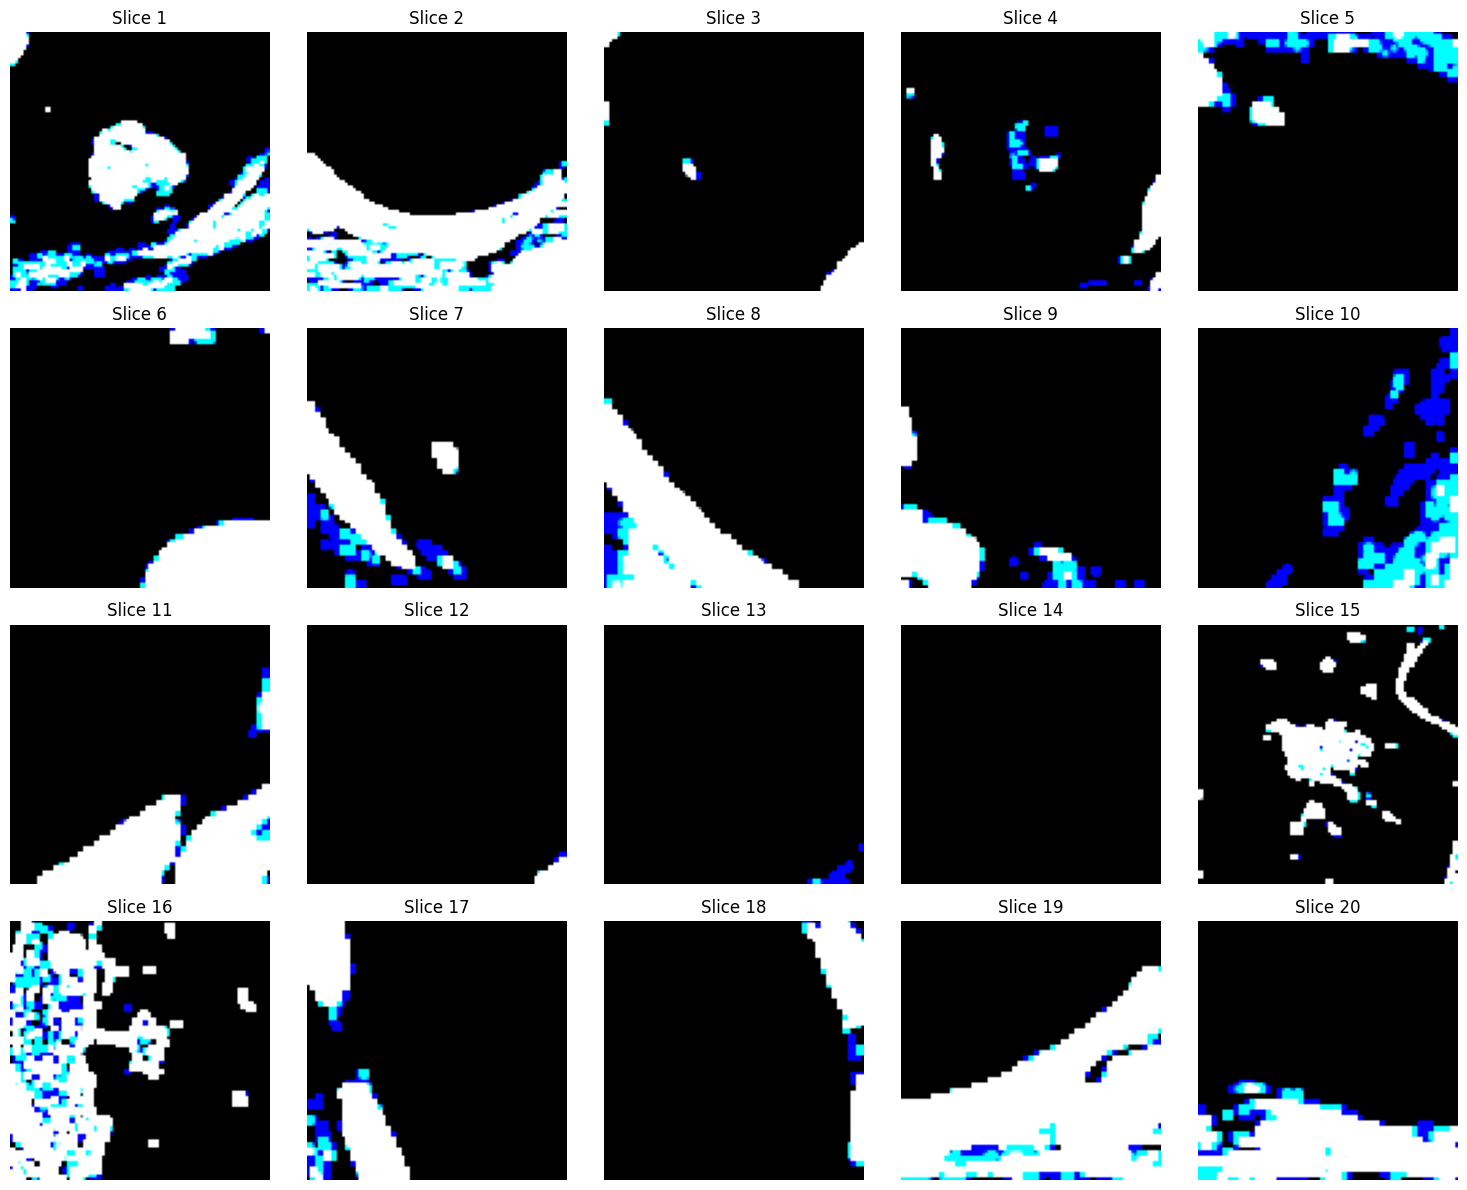

In [123]:
import matplotlib.pyplot as plt


num_images = 20
fig, axes = plt.subplots(4, 5, figsize=(15, 12))  # Arrange in a 4x5 grid
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < nodule_images.shape[0]:
        ax.imshow(nodule_images[i], cmap="gray")
        ax.set_title(f"Slice {i + 1}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [124]:
unique_classes, class_counts = np.unique(tumor_classes, return_counts=True)
total_samples = len(tumor_classes)
class_percentages = {cls: count / total_samples * 100 for cls, count in zip(unique_classes, class_counts)}
print("Class Percentages:")
for cls, perc in class_percentages.items():
    print(f"Class {cls}: {perc:.2f}%")

Class Percentages:
Class 0: 10.33%
Class 1: 19.34%
Class 2: 46.21%
Class 3: 17.69%
Class 4: 6.43%


In [125]:
class_weights = class_weight.compute_class_weight('balanced', classes=unique_classes, y=tumor_classes)
class_weights_dict = {i: weight for i, weight in zip(unique_classes, class_weights)}
print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.9368852459016392, 1: 1.0341356673960613, 2: 0.4327838827838828, 3: 1.130622009569378, 4: 3.1092105263157896}


In [126]:
def create_tf_dataset(images, labels, batch_size):
    labels = tf.one_hot(labels, depth=hp.num_classes)
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    #dataset = dataset.shuffle(buffer_size=len(images))
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [136]:
train_dataset = create_tf_dataset(X_train, y_train, hp.batch_size)
val_dataset = create_tf_dataset(X_val, y_val, hp.batch_size)

In [128]:
from tensorflow.keras.regularizers import l2

def build_model(hyperparams, backbone):
    # Add custom classification layers
    inputs = tfkl.Input(shape=hyperparams.input_shape)
    x = backbone(inputs)

    #x = tfkl.Conv2D(512, (2, 2), activation='silu', kernel_regularizer=l2(1e-5))(x)
    #x = tfkl.Conv2D(256, (2, 2), activation='silu', kernel_regularizer=l2(1e-5))(x)
    #x = tfkl.Flatten()(x)
    #x = tfkl.Dropout(0.6)(x)
    #x = tfkl.Dense(128, activation='silu')(x)
    #x = tfkl.Dense(64, activation='silu')(x)
    
    #x = tfkl.Dropout(0.4)(x)
    #outputs = tfkl.Dense(hp.num_classes, activation='softmax')(x)

    #x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(0.6)(x)
    x = tfkl.Dense(1024, activation=hp.activation)(x)
    x = tfkl.Dense(512, activation=hp.activation)(x)
    #x = tfkl.Dropout(0.2)(x)
    x = tfkl.Dense(256, activation=hp.activation)(x)
    #x = tfkl.Dropout(0.2)(x)
    x = tfkl.Dense(128, activation=hp.activation)(x)
    #x = tfkl.Dropout(0.2)(x)
    x = tfkl.Dense(64, activation=hp.activation)(x)
    x = tfkl.Dropout(0.3)(x)
    outputs = tfkl.Dense(5, activation="softmax")(x)

    model = Model(inputs, outputs)
    return model

In [137]:
backbone = tfk.applications.EfficientNetB0(
                include_top=False,
                weights='imagenet',
                input_tensor=None,
                input_shape=hp.input_shape,
                pooling='avg'
)


backbone.trainable = False

model = build_model(hp, backbone)

model.compile(optimizer=tfk.optimizers.Adam(learning_rate=hp.learning_rate),
              loss=tfk.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

model.fit(x=train_dataset,
          validation_data=val_dataset,
          epochs=100,
          class_weight=class_weights_dict,
          callbacks=[
            tfk.callbacks.EarlyStopping(monitor='val_loss',
                                        patience=hp.es_patience,
                                        min_delta=hp.es_min_delta,
                                        restore_best_weights=True,
                                        verbose=1),
            tfk.callbacks.ReduceLROnPlateau(
                monitor="val_loss",
                factor=0.3,
                patience=hp.lr_patience,
                min_lr=hp.min_lr,
                mode="min",
                verbose=1,
            )
          ]
         )

Model: "functional_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_59 (InputLayer)     │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_153 (Dense)               │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_154 (Dense)               │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_155 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_156 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_157 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,058,920 (23.11 MB)

 Trainable params: 2,009,349 (7.67 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 57s 586ms/step - accuracy: 0.2299 - loss: 1.6020 - val_accuracy: 0.3848 - val_loss: 1.5287 - learning_rate: 1.0000e-04
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3706 - loss: 1.4741 - val_accuracy: 0.4376 - val_loss: 1.3699 - learning_rate: 1.0000e-04
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4237 - loss: 1.3490 - val_accuracy: 0.4503 - val_loss: 1.3213 - learning_rate: 1.0000e-04
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4040 - loss: 1.3219 - val_accuracy: 0.4757 - val_loss: 1.3049 - learning_rate: 1.0000e-04
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4434 - loss: 1.2825 - val_accuracy: 0.4567 - val_loss: 1.3064 - learning_rate: 1.0000e-04
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4351 - loss: 1.2729 - val_accuracy: 0.4651 - val_loss: 1.2945 - learning_rate: 1.0000e-04
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy

In [111]:
for l in backbone.layers[:-20]:
    l.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=tfk.optimizers.Adam(learning_rate=hp.learning_rate * 0.1),
              loss=tfk.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Fine-tune the model
#fine_tune_epochs = 100

model.fit(x=train_dataset,
          validation_data=val_dataset,
          epochs=100,
          class_weight=class_weights_dict,
          callbacks=[
          tfk.callbacks.EarlyStopping(monitor='val_loss',
                                        patience=hp.es_patience,
                                        min_delta=hp.es_min_delta,
                                        restore_best_weights=True,
                                        verbose=1),
            tfk.callbacks.ReduceLROnPlateau(
                monitor="val_loss",
                factor=hp.lr_decay_factor,
                patience=hp.lr_patience,
                min_lr=hp.min_lr,
                mode="min",
                verbose=1,
            )
          ]
         )

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.1859 - loss: 1.7756 - val_accuracy: 0.3510 - val_loss: 1.4350 - learning_rate: 1.0000e-05
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.2565 - loss: 1.5460 - val_accuracy: 0.3636 - val_loss: 1.4308 - learning_rate: 1.0000e-05
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.3034 - loss: 1.4825 - val_accuracy: 0.3531 - val_loss: 1.4433 - learning_rate: 1.0000e-05
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.3287 - loss: 1.4159 - val_accuracy: 0.3510 - val_loss: 1.4510 - learning_rate: 1.0000e-05
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.3341 - loss: 1.4179 - val_accuracy: 0.3510 - val_loss: 1.4488 - learning_rate: 1.0000e-05
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.3605 - loss: 1.3506 - val_accuracy: 0.3552 - val_loss: 1.4375 - learning_rate: 1.0000e-05
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accu

KeyboardInterrupt: 

In [ ]:
for l in backbone.layers[:-12]:
    l.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=tfk.optimizers.Adam(learning_rate=hp.learning_rate * 0.01),
              loss=tfk.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Fine-tune the model
#fine_tune_epochs = 100

model.fit(x=train_dataset,
          validation_data=val_dataset,
          epochs=30,
          class_weight=class_weights_dict,
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=10)]
         )